In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.linalg import svd

In [2]:
with open('../graphs/export_graphs.pkl', 'rb') as file:
    export_graphs = pkl.load(file)

In [64]:
def jaccard_distance(G1, G2):
    # Convert the graphs to edge sets
    edge_set1 = set(G1.edges())
    edge_set2 = set(G2.edges())

    # Compute the intersection and union of the edge sets
    intersection = edge_set1 & edge_set2
    union = edge_set1 | edge_set2

    # Compute the Jaccard coefficient
    jaccard_coefficient = len(intersection) / len(union)

    # Compute the Jaccard distance
    jaccard_distance = 1 - jaccard_coefficient

    return jaccard_distance

In [3]:
def frobenius_distance(G1, G2):
    """
    Computes Frobenius distance between two graphs using the Frobenius norm.

    Parameters   
    G1, G2 (nx.Graph) : Graphs to compare
    Returns
    frobenius_distance (float) : frobenius distance between the two graphs
    """
    # Assuming 'G1' and 'G2' are your graphs
    w1 = nx.adjacency_matrix(G1.to_undirected()).toarray()
    w2 = nx.adjacency_matrix(G2.to_undirected()).toarray()

    w_diff = w1 - w2
    frobenius_distance = np.linalg.norm(w_diff, 'fro')
    return frobenius_distance

In [4]:
def pairwise_distance(graphs, dist_type):
    """
    Create pairwise matrix which contains the distance for every pair of graphs

    #Parameters
    graphs - list of graphs
    dist_type - specified distance function
    """
    i = len(graphs)
    distances = np.zeros(shape=(i,i))
    for i in range(len(graphs)):
        for j in range(len(graphs)):
            distances[i][j] = dist_type(graphs[i], graphs[j])
    return distances

In [158]:
with open('../distances/frobenius_distance_exports.pkl', 'rb') as file:
    frob_exports = pkl.load(file)

In [159]:
with open('../distances/procrustes_distance_exports.pkl', 'rb') as file:
    pro_exports = pkl.load(file)

In [65]:
jaccard_distances_exports = pairwise_distance(export_graphs, jaccard_distance)

In [203]:
import grakel as gk
from grakel.kernels import WeisfeilerLehman
from grakel.utils import graph_from_networkx

for g in export_graphs:
    nx.set_node_attributes(g, 1, 'label')

# Assuming G1 and G2 are your graphs
G = graph_from_networkx(export_graphs, node_labels_tag='label')

# Initialize a Weisfeiler-Lehman kernel
gk = WeisfeilerLehman(normalize=True)

G
# Compute the kernel matrix
kernel_matrix = gk.fit_transform(G)

In [205]:
# For each graph, get the 5 graphs most similar to it
most_similar_frob = [list(frob_exports[i].argsort()[1:10]) for i in range(frob_exports.shape[0])]
most_similar_pro = [list(pro_exports[i].argsort()[1:10]) for i in range(pro_exports.shape[0])]
most_similar_jac = [list(jaccard_distances_exports[i].argsort()[1:10]) for i in range(jaccard_distances_exports.shape[0])]
most_similar_wl = [list((-kernel_matrix[i]).argsort()[1:10]) for i in range(frob_exports.shape[0])]

Calculate test statistic to see if subgraphs belong to same group when break is at time t

n = group 1 (before t)

n' = group 2 (at or after t)

In [148]:
# Divide sequence of graphs into two groups - before and after time t
def knn_change_point(knn_clusters):
    N = len(export_graphs)
    r_stat = []
    for t in range(1,N):
        group_1 = range(t)
        group_2 = range(t,N)

        # b = 1 if at time t, graph 1 and graph 2 belong to two different time periods
        b_t = 0
        for n in group_1:
            for n_prime in group_2:
                knn_n_prime = knn_clusters[n_prime]
                knn_n = knn_clusters[n]
                    
                s_n_prime = 1 if n_prime in knn_n else 0
                s_n = 1 if n in knn_n_prime else 0
                b_t += 1 if (s_n_prime==0 and s_n == 0) else 0
        
        k = 3
        e_r = (4*k*t*(N-t))/(N-1)
        h = (4*(t-1)*(N-t-1))/((N-2)*(N-3))

        second_term = 0
        fourth_term = 0
        for n in range(N):
            second_term += (1 + k - ((2*(k**2))/(N-1)))
            fourth_term += (1-(k**2))

        second_term = (1/N)*second_term
        fourth_term = (1/N)*fourth_term

        third_term = (1-h)

        var = abs((e_r*h*second_term)+third_term+fourth_term)

        r_stat.append(-abs(b_t-e_r)/math.sqrt(var))

    return r_stat


In [206]:
r_stat_fro = knn_change_point(most_similar_frob)
r_stat_pro = knn_change_point(most_similar_pro)
r_stat_jac = knn_change_point(most_similar_jac)
r_stat_wl = knn_change_point(most_similar_wl)

In [150]:
t_range = range(1963,2022)

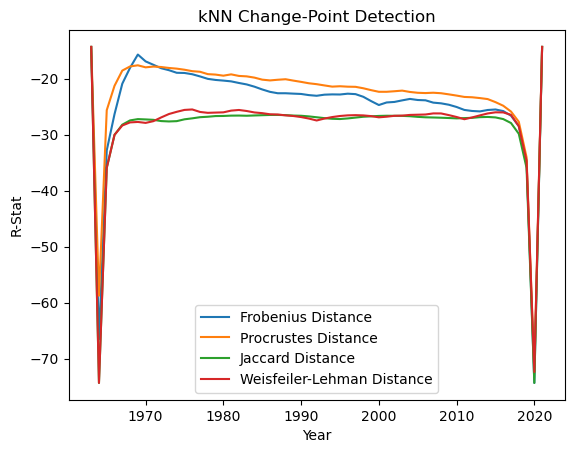

In [207]:
# Create a line graph of r_stat
plt.plot(t_range,r_stat_fro, label='Frobenius Distance')
plt.plot(t_range,r_stat_pro, label='Procrustes Distance')
plt.plot(t_range,r_stat_jac, label='Jaccard Distance')
plt.plot(t_range,r_stat_wl, label='Weisfeiler-Lehman Distance')
plt.title('kNN Change-Point Detection')
plt.xlabel('Year')
plt.ylabel('R-Stat')
plt.legend()
plt.show()